In [67]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold

plt.style.use('ggplot')
%matplotlib inline

x_train = pd.read_csv('data/x_train_norm.csv', sep=';', na_values='?')
x_test = pd.read_csv('data/x_test_norm.csv', sep=';', na_values='?')
y_train = pd.read_csv('data/y_train.csv', sep=';', header=None, na_values='?')[0]



# import scipy as sp
# def logloss(act, pred):
#     epsilon = 1e-15
#     pred = sp.maximum(epsilon, pred)
#     pred = sp.minimum(1-epsilon, pred)
#     ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
#     ll = ll * -1.0/len(act)
#     return ll

# def scorer_logloss(estimator, X, y):
#     return logloss(y, estimator.predict_proba(X)[:,1])

def scorer_logloss(estimator, X, y):
    return log_loss(y, estimator.predict_proba(X)) # аналогично этому: estimator.predict_proba(X)[:,1]

def revert_scorer_logloss(estimator, X, y):
    return -1 * scorer_logloss(estimator, X, y)
# # read in data
# dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
# dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
# num_round = 2
# bst = xgb.train(param, dtrain, num_round)
# # make prediction
# preds = bst.predict(dtest)


In [5]:
classifier = xgb.XGBClassifier()

In [6]:
crossed = cross_val_score(classifier, x_train, y_train, scoring=scorer_logloss, n_jobs=3)

In [7]:
crossed

array([ 0.38403126,  0.37941666,  0.38666644])

In [9]:
xgb.DMatrix(x_train, label=y_train)

In [12]:
x_train.values

array([[ 1.03107779, -0.18642199, -0.06652753, ..., -0.20096117,
        -0.2583056 ,  1.        ],
       [ 0.13175117,  0.74032995,  2.34186796, ...,  0.82190428,
         0.46877682,  1.        ],
       [-0.66765028, -0.49533931, -0.36757697, ..., -0.43962977,
        -0.62184681,  0.        ],
       ..., 
       [-0.61768769, -0.41810998, -0.21705225, ..., -0.37143874,
        -0.62184681,  0.        ],
       [ 1.83047923, -0.88148595, -0.36757697, ..., -0.88287146,
        -0.62184681,  1.        ],
       [-0.86750064, -0.80425662, -0.36757697, ..., -0.81468043,
        -0.62184681,  0.        ]])

In [18]:
def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y ,eval_metric='logloss')
        
    #Predict training set:
    #dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print "\nModel Report"
    #print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
    print 'logloss: %f' % log_loss(y, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
logloss: 0.363009


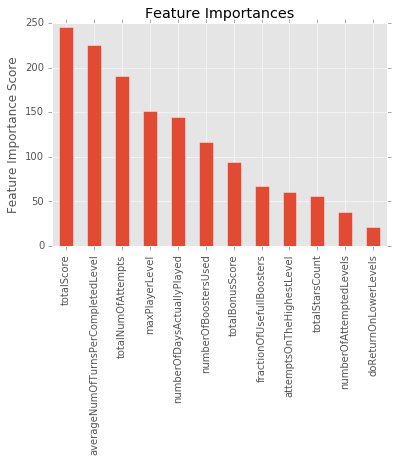

In [19]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, x_train, y_train)

In [22]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1,
        n_estimators=140,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test1,
    scoring=revert_scorer_logloss,
    n_jobs=4,
    iid=False,
    cv=3)

gsearch1.fit(x_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, -gsearch1.best_score_

/Users/kurtov/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.38306, std: 0.00302, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.38301, std: 0.00310, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.38278, std: 0.00304, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.38718, std: 0.00469, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.38702, std: 0.00448, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.38629, std: 0.00450, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.39451, std: 0.00558, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.39412, std: 0.00540, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.39279, std: 0.00582, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.40611, std: 0.00714, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.40312, std: 0.00703, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.39750, std: 0.00512, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_chil

In [23]:
param_test1 = {
 'max_depth':range(1,10),
 'min_child_weight':range(1,10)
}
gsearch1 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1,
        n_estimators=140,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test1,
    scoring=revert_scorer_logloss,
    n_jobs=4,
    iid=False,
    cv=3)

gsearch1.fit(x_train, y_train)
#gsearch1.cv_results_, 
gsearch1.best_params_, -gsearch1.best_score_

({'mean_fit_time': array([ 1.07926202,  1.09394296,  0.93116363,  0.87342731,  0.83454736,
          0.92734496,  1.00486525,  0.88095164,  0.84354536,  1.29614798,
          1.3009963 ,  1.29499896,  1.29136944,  1.32265162,  1.36866736,
          1.45422339,  1.32169692,  1.37199664,  1.89302897,  1.78734525,
          1.78001602,  1.77726698,  1.83173275,  1.83297332,  1.76836435,
          1.80830423,  2.14240996,  2.77741226,  2.93552264,  2.94469062,
          3.14646594,  2.76131972,  2.28909024,  2.34223   ,  2.61511   ,
          2.55215343,  3.17459965,  3.10463699,  2.87395906,  2.95961062,
          2.95515172,  3.17239833,  2.96269894,  3.02299968,  2.9959867 ,
          3.62675031,  3.54419041,  3.51636068,  3.34216301,  3.56515368,
          4.07761629,  5.32237601,  5.59084702,  4.46849028,  4.87117195,
          4.14528831,  3.83524998,  3.82953564,  4.16136694,  4.61953966,
          4.36346165,  4.01352843,  3.99123359,  4.65512554,  4.56368899,
          4.512405  ,

In [25]:
max_depth_opt = 3
min_child_weight_opt = 9
# cv = 0.38253670876650864

In [31]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1,
        n_estimators=140,
        max_depth=max_depth_opt,
        min_child_weight=min_child_weight_opt,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
     param_grid = param_test3,
    scoring=revert_scorer_logloss,
    n_jobs=4,
    iid=False,
    cv=3)

gsearch3.fit(x_train, y_train)
gsearch3.best_params_, -gsearch3.best_score_

({'gamma': 0.0}, 0.38253670876650864)

In [28]:
gamma_opt = 0


Model Report
logloss: 0.368965


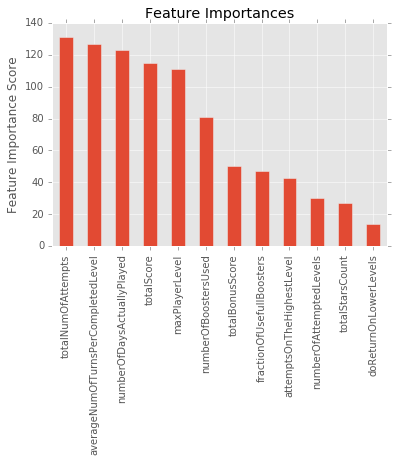

In [29]:
xgb2 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=140,
    max_depth=max_depth_opt,
    min_child_weight=min_child_weight_opt,
    gamma=gamma_opt,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb2, x_train, y_train)

In [33]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(2,10)]
}

gsearch4 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1,
        n_estimators=140,
        max_depth=max_depth_opt,
        min_child_weight=min_child_weight_opt,
        gamma=gamma_opt,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
     param_grid = param_test4,
    scoring=revert_scorer_logloss,
    n_jobs=4,
    iid=False,
    cv=3)

gsearch4.fit(x_train, y_train)
gsearch4.best_params_, -gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.8}, 0.38237409726121907)

In [34]:
colsample_bytree_opt = 0.6
subsample_opt = 0.8

In [42]:
param_test5 = {
 'subsample':[i/100.0 for i in np.arange(subsample_opt*100-10,subsample_opt*100+11,2)],
 'colsample_bytree':[i/100.0 for i in np.arange(colsample_bytree_opt*100-10,colsample_bytree_opt*100+11,2)]
}

gsearch5 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1,
        n_estimators=140,
        max_depth=max_depth_opt,
        min_child_weight=min_child_weight_opt,
        gamma=gamma_opt,
        subsample=subsample_opt,
        colsample_bytree=colsample_bytree_opt,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
     param_grid = param_test5,
    scoring=revert_scorer_logloss,
    n_jobs=4,
    iid=False,
    cv=3)


gsearch5.fit(x_train, y_train)
gsearch5.best_params_, -gsearch5.best_score_

({'colsample_bytree': 0.59999999999999998, 'subsample': 0.76000000000000001},
 0.38216624587869469)

In [43]:
# Уточненные значения
colsample_bytree_opt = 0.6
subsample_opt = 0.76

In [50]:
param_test6 = {
 'reg_alpha': np.concatenate([np.linspace(1e-5 - 1e-5/2, 1e-5 + 1e-5/2, 10), [1e-2, 0.1, 1, 100]]) #[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1,
        n_estimators=140,
        max_depth=max_depth_opt,
        min_child_weight=min_child_weight_opt,
        gamma=gamma_opt,
        subsample=subsample_opt,
        colsample_bytree=colsample_bytree_opt,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test6,
    scoring=revert_scorer_logloss,
    n_jobs=4,
    iid=False,
    cv=3)

gsearch6.fit(x_train, y_train)
gsearch6.best_params_, -gsearch6.best_score_

({'reg_alpha': 8.3333333333333337e-06}, 0.38216624477779176)

In [52]:
reg_alpha_opt = (8+1.0/3)*1e-6


Model Report
logloss: 0.369666


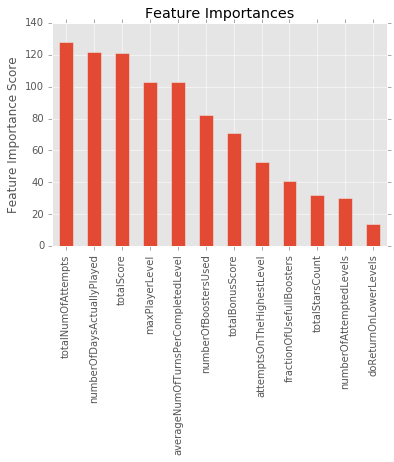

In [59]:
xgb3 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=140,
    max_depth=max_depth_opt,
    min_child_weight=min_child_weight_opt,
    gamma=gamma_opt,
    subsample=subsample_opt,
    colsample_bytree=colsample_bytree_opt,
    reg_alpha=reg_alpha_opt,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb3, x_train, y_train)

In [61]:
learning_rate=0.1
n_estimators=140
fractions=np.array([0.5,1,5,10,15,20,25,30])

param_test7 = [{'learning_rate': [learning_rate/frac], 'n_estimators': [int(n_estimators*frac)]} for frac in fractions]

gsearch7 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate =0.1,
        n_estimators=140,
        max_depth=max_depth_opt,
        min_child_weight=min_child_weight_opt,
        gamma=gamma_opt,
        subsample=subsample_opt,
        colsample_bytree=colsample_bytree_opt,
        reg_alpha=reg_alpha_opt,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27), 
    param_grid = param_test7,
    scoring=revert_scorer_logloss,
    n_jobs=4,
    iid=False,
    cv=3)

gsearch7.fit(x_train, y_train)
gsearch7.best_params_, -gsearch7.best_score_

({'learning_rate': 0.10000000000000001, 'n_estimators': 140},
 0.38216624477779176)

In [62]:
learning_rate_opt = 0.0050000000000000001
n_estimators_opt = 2800

In [63]:
classifier = XGBClassifier(
    learning_rate=learning_rate_opt,
    n_estimators=n_estimators_opt,
    max_depth=max_depth_opt,
    min_child_weight=min_child_weight_opt,
    gamma=gamma_opt,
    subsample=subsample_opt,
    colsample_bytree=colsample_bytree_opt,
    reg_alpha=reg_alpha_opt,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

In [64]:
classifier.get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.005,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 9,
 'missing': None,
 'n_estimators': 2800,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 8.333333333333334e-06,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': True,
 'subsample': 0.76}

In [65]:
classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/009_xgb_n_est_2800.csv', sep=';', header=None, index=False)

In [73]:
classifier = XGBClassifier(base_score=0.5,
 colsample_bylevel= 1,
 colsample_bytree= 0.6,
 gamma= 0,
 learning_rate= 0.005,
 max_delta_step= 0,
 max_depth= 3,
 min_child_weight= 9,
 missing= None,
 n_estimators= 2800,
 nthread= 4,
 objective= 'binary:logistic',
 reg_alpha= 8.333333333333334e-06,
 reg_lambda= 1,
 scale_pos_weight= 1,
 seed= 27,
 silent= True,
 subsample= 0.76)

cross_val_score(classifier, x_train, y_train, scoring=revert_scorer_logloss, n_jobs=4)

array([-0.38228068, -0.37842793, -0.38572112])

In [74]:
classifier = XGBClassifier(base_score=0.5,
 colsample_bylevel= 1,
 colsample_bytree= 0.6,
 gamma= 0,
 learning_rate= 0.005,
 max_delta_step= 0,
 max_depth= 3,
 min_child_weight= 9,
 missing= None,
 n_estimators= 2800,
 nthread= 4,
 objective= 'binary:logistic',
 reg_alpha= 8.333333333333334e-06,
 reg_lambda= 1,
 scale_pos_weight= 0.5,
 seed= 27,
 silent= True,
 subsample= 0.76)

cross_val_score(classifier, x_train, y_train, scoring=revert_scorer_logloss, n_jobs=4)

array([-0.40989461, -0.40722043, -0.40836035])